In [3]:
import pandas as pd
from config import  DATA_DIR
import numpy as np
import ast


In [4]:
def squared_errors(true, preds):
    # Ensure the inputs are NumPy arrays for element-wise operations
    true = np.array(true).ravel()
    preds = np.array(preds).ravel()[0:len(true)]
    print(true)
    print(preds)

    # Check if both arrays have the same length
    if true.shape != preds.shape:
        raise ValueError("The length of true values and predictions must be the same.")

    # Calculate squared errors, ignoring np.nan values
    errors = (true - preds) ** 2

    # Filter out np.nan values
    errors_filtered = errors[~np.isnan(errors)]

    return list(errors_filtered)

In [5]:
forecasts = pd.read_excel(r"C:\Users\beerp\git-repos\HRNN\results\forecasts_ar.xlsx", index_col=0)
forecasts_gru = pd.read_excel(r"C:\Users\beerp\git-repos\HRNN\results\forecasts.xlsx", index_col=0)

# Load some data
cpi_data = pd.read_excel(DATA_DIR + '/public_data_april.xlsx', index_col=0)[['C000000', 'SA07']]
data = cpi_data['C000000'].dropna()
data

date
1996-01-01     67.94
1996-02-01     68.29
1996-03-01     69.11
1996-04-01     69.32
1996-05-01     69.04
               ...  
2022-12-01    126.64
2023-01-01    124.23
2023-02-01    125.90
2023-03-01    126.16
2023-04-01    128.17
Name: C000000, Length: 328, dtype: float64

In [45]:
ast.literal_eval(forecasts[(forecasts.model_specification=='AR(1)') & (forecasts.month=='2019-01-01')].forecast_values.values[0])

[103.20482606175348,
 103.27939864770849,
 103.35371861652281,
 103.42778682394548,
 103.50160412282669,
 103.57517136312755,
 103.6484893919299,
 103.72155905344606,
 103.79438118902856,
 103.86695663717983,
 103.93928623356182,
 104.01137081100566]

In [59]:
month=pd.to_datetime('2018-01-01')
data.loc[month+pd.DateOffset(months=1):month+pd.DateOffset(months=12)]

date
2018-02-01    101.84
2018-03-01    102.06
2018-04-01    102.99
2018-05-01    103.41
2018-06-01    102.85
2018-07-01    103.96
2018-08-01    104.09
2018-09-01    103.36
2018-10-01    103.89
2018-11-01    103.37
2018-12-01    103.35
2019-01-01    103.13
Name: C000000, dtype: float64

In [77]:
month = '2018-03-01'

first_pred = pd.to_datetime(month) + pd.DateOffset(months=1)

forecasts_gru.loc[first_pred].values

array([ 0.0741245 ,  0.05830459,  0.03994653,  0.0258888 ,  0.01548277,
        0.00794022,  0.00255735, -0.00123969, -0.00389652, -0.00574591,
       -0.00702922, -0.00791817])

In [ ]:
h_gru_params = {'hidden_gru_units': 10, 'epochs': 10000, 'batch_size': 50, 'verbose': 1,
                'recurrent_reg': 0.05, 'kernel_reg': 0.1, "num_layers": 2, "lr": 0.0001,
                'smoothing': 'exp', 'benchmark': benchmark, 'alpha': 1.5, 'patience': 10}

In [30]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler

def define_gru_model(sequence_length):
    def revert_growth_rates_to_levels(last_level, growth_rates):
        levels = [last_level]
        for growth_rate in growth_rates:
            new_level = levels[-1] * (1 + growth_rate)
            levels.append(new_level)
        return levels[1:]

    def forecast_model(data_input, forecast_horizon):
        
        data = data_input.copy()
        data = data.pct_change(1).dropna()

        # Normalize the data
        scaler = MinMaxScaler(feature_range=(0, 1))
        data_normalized = scaler.fit_transform(np.array(data).reshape(-1, 1))

        # Function to create sequences for forecasting
        def create_sequences(data, sequence_length):
            xs, ys = [], []
            for i in range(len(data) - sequence_length):
                x = data[i:(i + sequence_length)]
                y = data[i + sequence_length]
                xs.append(x)
                ys.append(y)
            return np.array(xs), np.array(ys)

        # Create sequences
        X, y = create_sequences(data_normalized, sequence_length)

        # Build the GRU model
        model = Sequential()
        model.add(GRU(units=10, return_sequences=True, input_shape=(sequence_length, 1)))
        model.add(GRU(units=10))
        model.add(Dense(1))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer, loss='mean_squared_error')

        # Early stopping callback
        early_stopping = EarlyStopping(monitor='loss', patience=10, mode='min', restore_best_weights=True)

        # Train the model with early stopping
        model.fit(X, y, epochs=10000, batch_size=50, verbose=1, callbacks=[early_stopping])

        # Forecasting
        forecast = []
        current_batch = data_normalized[-sequence_length:].reshape(1, sequence_length, 1)
        for i in range(forecast_horizon):
            current_pred = model.predict(current_batch)[0]
            forecast.append(current_pred)
            current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

        # Inverse transform to original scale
        forecast = scaler.inverse_transform(forecast).flatten()

        # Revert growth rates to levels
        last_known_level = data_input.iloc[-1]
        forecast_level = revert_growth_rates_to_levels(last_known_level, forecast)

        # Create a pandas Series with datetime index
        start_date = pd.to_datetime(data.index[-1]) + pd.DateOffset(months=1)
        dates = pd.date_range(start=start_date, periods=forecast_horizon, freq='MS')
        forecast_series = pd.Series(forecast_level, index=dates)

        return forecast_series

    return forecast_model

# Example usage
sequence_length = 4  # Define the sequence length
defined_model = define_gru_model(sequence_length)

# Assuming 'level_data' is your pandas Series with datetime index
data = level_data.dropna()  # Replace with your data
forecast_horizon = 12  # Number of steps to forecast

forecast_series = defined_model(data, forecast_horizon)
print('Forecast:', forecast_series)


Epoch 1/10000
7/7 [==============================] - 2s 3ms/step - loss: 0.2027
Epoch 2/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.1946
Epoch 3/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.1868
Epoch 4/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.1791
Epoch 5/10000
7/7 [==============================] - 0s 4ms/step - loss: 0.1716
Epoch 6/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.1644
Epoch 7/10000
7/7 [==============================] - 0s 4ms/step - loss: 0.1573
Epoch 8/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.1504
Epoch 9/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.1437
Epoch 10/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.1372
Epoch 11/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.1309
Epoch 12/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.1247
Epoch 13/10000
7/7 [=================

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from sklearn.preprocessing import MinMaxScaler

def revert_growth_rates_to_levels(last_level, growth_rates):
    """
    Reverts growth rates to level predictions.

    :param last_level: The last known level of the time series.
    :param growth_rates: A list or array of growth rates.
    :return: A list of level predictions.
    """
    levels = [last_level]
    for growth_rate in growth_rates:
        new_level = levels[-1] * (1 + growth_rate)
        levels.append(new_level)
    
    return levels[1:]  # Exclude the initial level

def forecast_model(data, forecast_horizon, sequence_length=4, epochs=10000, batch_size=50):
    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0, 1))
    data_normalized = scaler.fit_transform(np.array(data).reshape(-1, 1))

    # Function to create sequences for one-step-ahead forecasting
    def create_sequences(data, sequence_length):
        xs, ys = [], []
        for i in range(len(data) - sequence_length):
            x = data[i:(i + sequence_length)]
            y = data[i + sequence_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

    # Create sequences
    X, y = create_sequences(data_normalized, sequence_length)

    # Build the GRU model with regularization
    #reg = l1_l2(l1=0.1, l2=0.05)  # Regularization
    model = Sequential()
    model.add(GRU(units=10, return_sequences=True, input_shape=(sequence_length, 1)))#, kernel_regularizer=reg, recurrent_regularizer=reg))
    model.add(GRU(units=10))#, kernel_regularizer=reg, recurrent_regularizer=reg))
    model.add(Dense(1))
    
    # Custom optimizer with specified learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Early stopping callback
    early_stopping = EarlyStopping(monitor='loss', patience=10, mode='min', restore_best_weights=True)

    # Train the model with early stopping
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

    # Forecasting
    forecast = []
    current_batch = data_normalized[-sequence_length:].reshape(1, sequence_length, 1)
    
    for i in range(forecast_horizon):
        # Get the next prediction
        current_pred = model.predict(current_batch)[0]
        
        # Append the prediction
        forecast.append(current_pred)
        
        # Use the prediction to update the batch and remove the first value
        current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

    # Inverse transform to original scale
    forecast = scaler.inverse_transform(forecast).flatten()

    return forecast

level_data = cpi_data['C000000'].dropna()

# Example usage
data = level_data.pct_change(1).dropna().tolist()  # Replace with your data
forecast_horizon = 12  # Number of steps to forecast

forecast = forecast_model(data, forecast_horizon)
forecast_level = revert_growth_rates_to_levels(last_level=level_data.iloc[-1], growth_rates=forecast)

print('Forecast:', forecast_level)


Epoch 1/10000
7/7 [==============================] - 2s 3ms/step - loss: 0.3160
Epoch 2/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.3024
Epoch 3/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2894
Epoch 4/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2767
Epoch 5/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2646
Epoch 6/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2528
Epoch 7/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2414
Epoch 8/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2305
Epoch 9/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2200
Epoch 10/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2098
Epoch 11/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.2000
Epoch 12/10000
7/7 [==============================] - 0s 3ms/step - loss: 0.1905
Epoch 13/10000
7/7 [=================

In [35]:
data.to_frame().rename(columns = {'C000000': 'true_value'})

,true_value
date,
1996-01-01,67.94
1996-02-01,68.29
1996-03-01,69.11
1996-04-01,69.32
1996-05-01,69.04
...,...
2022-12-01,126.64
2023-01-01,124.23
2023-02-01,125.90


In [38]:
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Sample data (replace this with your actual DataFrames)
# Assuming df_true has columns ['date', 'true_value']
df_forecast = pd.read_excel(r"C:\Users\beerp\git-repos\HRNN\results\forecasts.xlsx", index_col=0)
df_true = data.to_frame().rename(columns = {'C000000': 'true_value'})

df_forecast['forecast_values'] = df_forecast['forecast_values'].apply(lambda x: ast.literal_eval(x))

# Reshape the forecast DataFrame
forecasts = []
for index, row in df_forecast.iterrows():
    model = row['model_specification']
    date = row['month']
    for i, value in enumerate(row['forecast_values']):
        forecasts.append([model, date, i+1, value])  # i+1 represents the forecast horizon

df_forecast_expanded = pd.DataFrame(forecasts, columns=['model', 'date', 'horizon', 'forecast_value'])

# Merge with true values
df_true['horizon'] = df_true.groupby('date').cumcount() + 1
df_combined = pd.merge(df_forecast_expanded, df_true, on=['date', 'horizon'])

# Function to calculate metrics
def calculate_metrics(df, horizon=None):
    if horizon and df['horizon'].max() < horizon:
        return None  # Skip if not enough data for the specified horizon
    if horizon:
        df = df[df['horizon'] == horizon]
    mse = mean_squared_error(df['true_value'], df['forecast_value'])
    mae = mean_absolute_error(df['true_value'], df['forecast_value'])
    return mse, mae

# Total performance
total_performance = df_combined.groupby('model').apply(calculate_metrics)

# Performance for different horizons
one_step_performance = df_combined.groupby('model').apply(lambda x: calculate_metrics(x, horizon=1))
six_step_performance = df_combined.groupby('model').apply(lambda x: calculate_metrics(x, horizon=6))
total_horizon_performance = df_combined.groupby('model').apply(calculate_metrics)

# Print or store the results
print("Total Performance:", total_performance)
print("One Step Performance:", one_step_performance)
print("Six Step Performance:", six_step_performance)
print("Total Horizon Performance:", total_horizon_performance)

Total Performance: model
AR(1)     (0.026466786285026675, 0.1296626411943996)
AR(2)     (0.10276540063424854, 0.22896135113055702)
AR(3)      (0.17009954591706086, 0.3077561480910978)
AR(4)        (0.241813367832719, 0.3380571888325738)
GRU(1)    (0.12966300397808436, 0.27456579914969675)
GRU(2)    (0.11611966020495547, 0.27993804416245655)
GRU(3)     (0.15263691680098443, 0.3122206172216444)
GRU(4)    (0.16513788828445214, 0.29956622620420004)
dtype: object
One Step Performance: model
AR(1)     (0.026466786285026675, 0.1296626411943996)
AR(2)     (0.10276540063424854, 0.22896135113055702)
AR(3)      (0.17009954591706086, 0.3077561480910978)
AR(4)        (0.241813367832719, 0.3380571888325738)
GRU(1)    (0.12966300397808436, 0.27456579914969675)
GRU(2)    (0.11611966020495547, 0.27993804416245655)
GRU(3)     (0.15263691680098443, 0.3122206172216444)
GRU(4)    (0.16513788828445214, 0.29956622620420004)
dtype: object
Six Step Performance: Empty DataFrame
Columns: []
Index: []
Total Horiz

In [28]:
from benchmarks import define_ar_model

# Define the AR model with a specific lag
lag_value = 5  # Example lag value
defined_model = define_ar_model(lag_value)

# Now use this model to make a forecast
data = level_data # Replace with your time series data
horizon = 12  # Forecast horizon
forecast = defined_model(data, horizon)

# forecast now contains the forecasted values
print(forecast)


2023-05-01    128.398255
2023-06-01    128.770926
2023-07-01    128.627638
2023-08-01    128.938442
2023-09-01    129.319312
2023-10-01    129.876960
2023-11-01    130.331361
2023-12-01    130.738623
2024-01-01    131.082245
2024-02-01    131.447303
2024-03-01    131.835937
2024-04-01    132.252549
Freq: MS, dtype: float64


c:\Users\beerp\anaconda3\envs\my-hrnn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\beerp\anaconda3\envs\my-hrnn\lib\site-packages\statsmodels\tsa\deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


In [89]:
predictions

array([[101.37622 ],
       [101.25408 ],
       [101.05258 ],
       [101.05388 ],
       [101.146126],
       [101.49312 ],
       [101.94928 ],
       [102.26024 ],
       [102.6276  ],
       [102.99167 ],
       [103.0679  ],
       [103.143364],
       [103.15228 ],
       [103.025856],
       [102.86312 ],
       [103.05947 ],
       [103.40269 ],
       [104.03755 ],
       [104.57571 ],
       [104.95446 ],
       [105.31476 ],
       [105.75865 ],
       [105.83767 ],
       [105.97318 ],
       [105.930046],
       [105.80001 ],
       [105.35768 ],
       [105.19169 ],
       [105.137634],
       [105.447975],
       [105.740166],
       [106.18657 ],
       [106.691666],
       [106.970795],
       [106.94803 ],
       [107.06254 ],
       [106.876076],
       [106.67116 ],
       [106.44213 ],
       [106.51929 ],
       [106.68857 ],
       [107.17478 ],
       [107.62807 ],
       [108.086464],
       [108.48951 ],
       [108.94928 ],
       [109.2564  ],
       [109.8

In [88]:
cpi_data['C000000'].dropna()[0:train_size]

date
1996-01-01     67.94
1996-02-01     68.29
1996-03-01     69.11
1996-04-01     69.32
1996-05-01     69.04
               ...  
2017-02-01    100.58
2017-03-01    101.03
2017-04-01    101.94
2017-05-01    101.49
2017-06-01    101.17
Name: C000000, Length: 258, dtype: float64

In [31]:
models

NameError: name 'models' is not defined

In [56]:
model

'A'

In [63]:
df_forecast[(df_forecast.model_specification==model) & (df_forecast.month==month)].forecast_values.values[0]

[98.10006030974301,
 98.16981154948664,
 98.23925508268852,
 98.30839226679142,
 98.37722445324975,
 98.44575298755605,
 98.51397920926719,
 98.58190445203063,
 98.64953004361044,
 98.71685730591331,
 98.78388755501433,
 98.85062210118278]

In [64]:
df_forecast.month = pd.to_datetime(df_forecast.month)
models = np.unique(df_forecast.model_specification)
months = [pd.to_datetime(month) for month in np.unique(df_forecast.month)]
results = {}

for model in models:

    mses_1 = []
    mses_6 = []
    mses_12 = []

    for month in months:
        true = list(data.loc[month+pd.DateOffset(months=1):month+pd.DateOffset(months=12)])

        preds = df_forecast[(df_forecast.model_specification==model) & (df_forecast.month==month)].forecast_values.values[0]
        if isinstance(preds, str):
            preds = ast.literal_eval(preds)
        ses = squared_errors(true, preds) 

        if len(ses) >= 1:
            mses_1 += [ses[0]]

        if len(ses) >= 6:
            mses_6 += [np.mean(ses[0:6])]

        if len(ses) >= 12:
            mses_12 += [np.mean(ses[0:12])]

    results[model] = {'1': mses_1, '6': mses_6, '12': mses_12}


[ 98.94 100.4  100.51 100.75 100.2  100.5  100.67 100.31 100.67 100.02
 100.27  99.64]
[98.10006031 98.16981155 98.23925508 98.30839227 98.37722445 98.44575299
 98.51397921 98.58190445 98.64953004 98.71685731 98.78388756 98.8506221 ]
[100.4  100.51 100.75 100.2  100.5  100.67 100.31 100.67 100.02 100.27
  99.64 100.58]
[99.0153183  99.09033687 99.1650569  99.23947958 99.3136061  99.38743764
 99.46097536 99.53422043 99.60717403 99.67983731 99.75221143 99.82429753]
[100.51 100.75 100.2  100.5  100.67 100.31 100.67 100.02 100.27  99.64
 100.58 101.03]
[100.48641002 100.57254145 100.65839517 100.74397209 100.82927309
 100.91429906 100.9990509  101.08352949 101.1677357  101.25167041
 101.33533451 101.41872886]
[100.75 100.2  100.5  100.67 100.31 100.67 100.02 100.27  99.64 100.58
 101.03 101.94]
[100.59636172 100.6824462  100.76825435 100.85378705 100.93904519
 101.02402963 101.10874127 101.19318099 101.27734964 101.3612481
 101.44487725 101.52823794]
[100.2  100.5  100.67 100.31 100.67 100

In [79]:
models

array(['AR(1)', 'AR(2)', 'AR(3)', 'AR(4)', 'GRU(1)', 'GRU(2)', 'GRU(3)',
       'GRU(4)'], dtype=object)

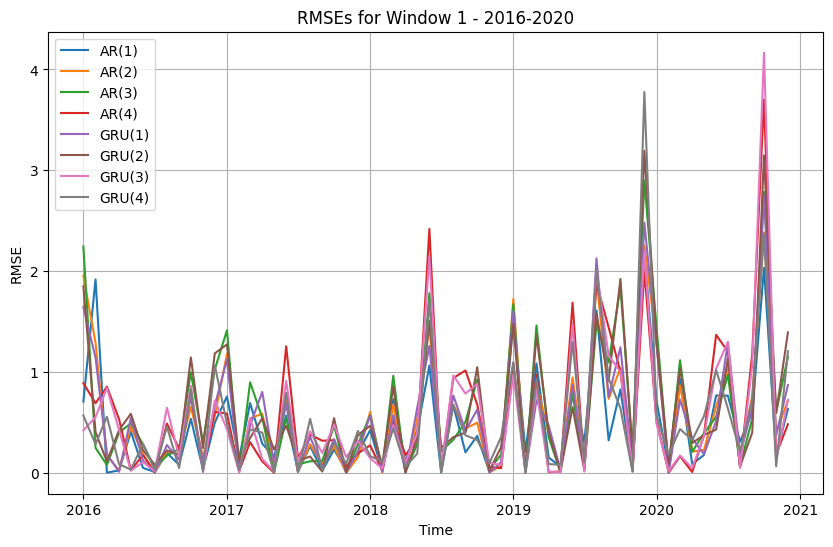

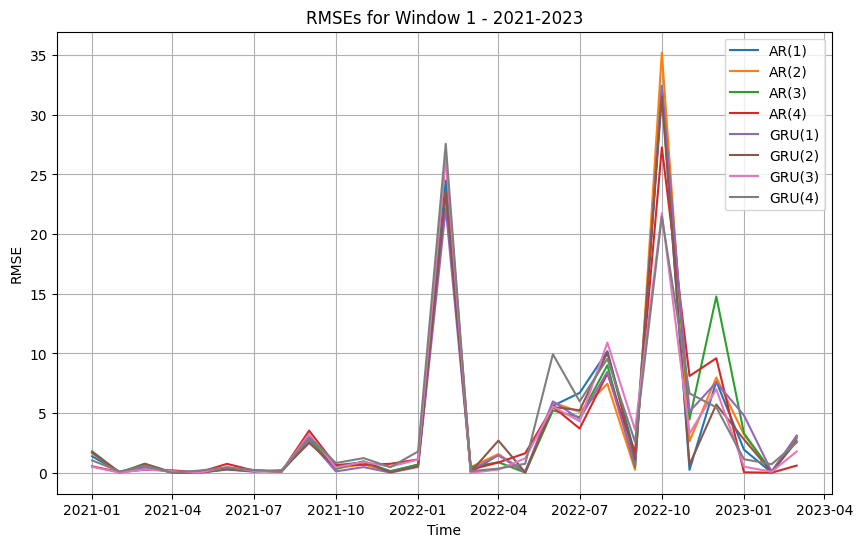

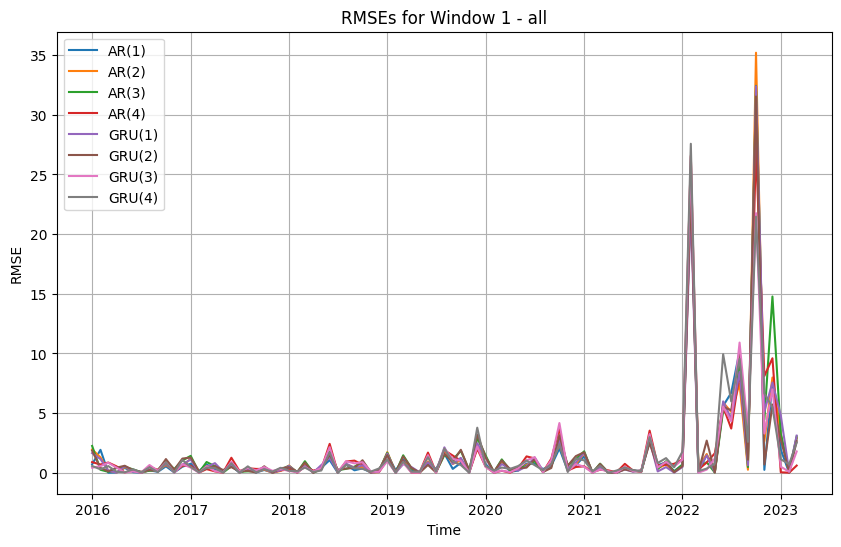

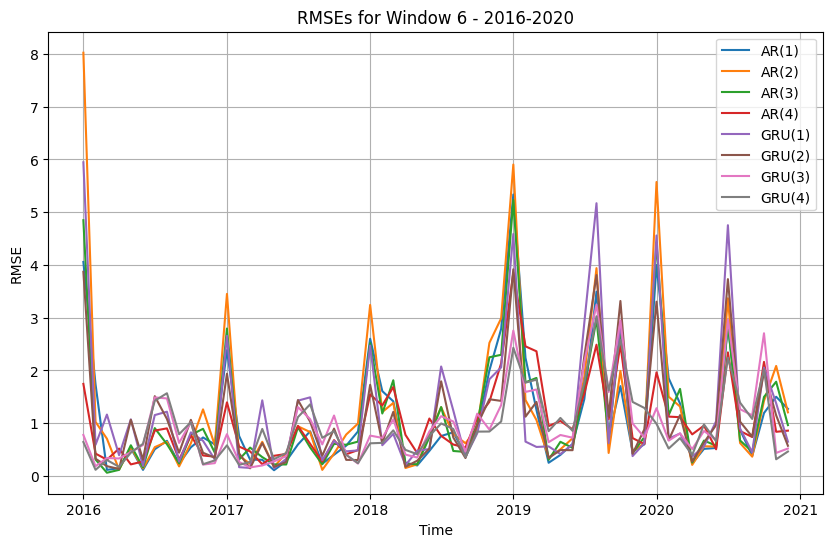

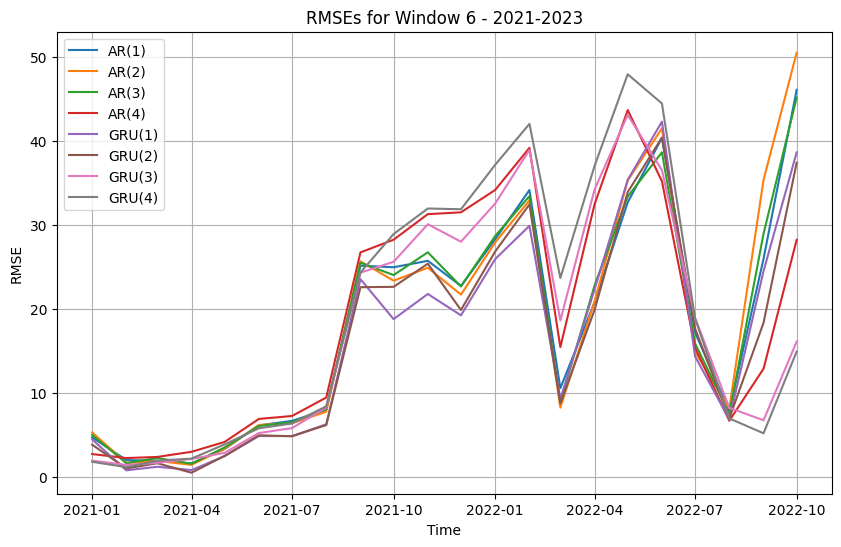

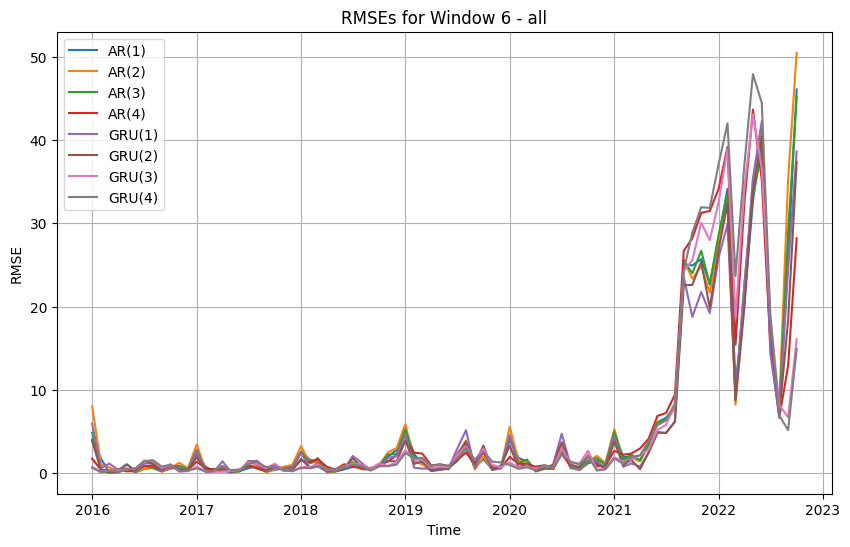

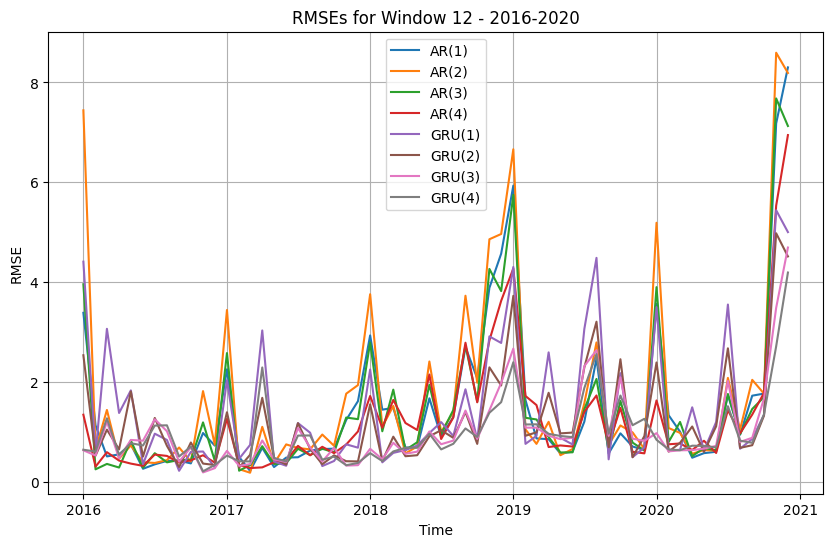

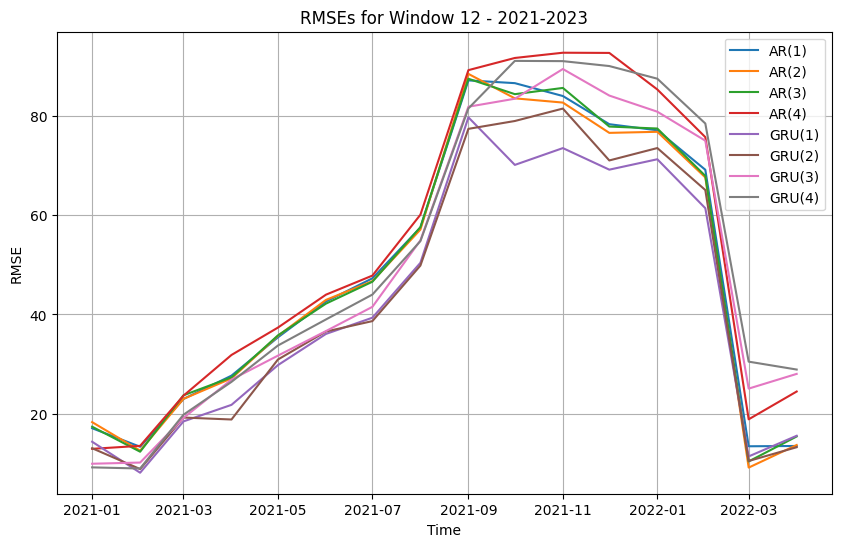

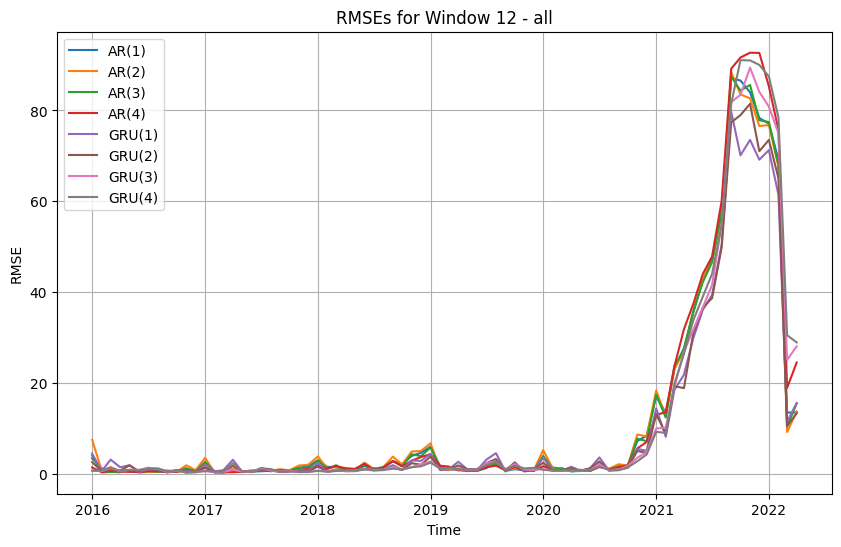

   Window       Part   Model  Average RMSE
0       1  2016-2020   AR(1)      0.470851
1       1  2016-2020   AR(2)      0.561751
2       1  2016-2020   AR(3)      0.642831
3       1  2016-2020   AR(4)      0.580789
4       1  2016-2020  GRU(1)      0.573049
..    ...        ...     ...           ...
67     12        all   AR(4)     12.055603
68     12        all  GRU(1)      9.989292
69     12        all  GRU(2)     10.000407
70     12        all  GRU(3)     11.046495
71     12        all  GRU(4)     11.502302

[72 rows x 4 columns]


In [87]:
import matplotlib.pyplot as plt
import pandas as pd

model_dict = results  # Assuming 'results' is your dictionary
x_axis = months  # Assuming 'months' is your list for the x-axis

# Create an empty DataFrame to store the averages
average_df = pd.DataFrame(columns=['Window', 'Part', 'Model', 'Average RMSE'])

# Iterate over each window and create two plots for each window
for window in ['1', '6', '12']:
    for part in ['2016-2020', '2021-2023', 'all']:  # Two parts: first 60 values (part 1) and the rest (part 2)
        plt.figure(figsize=(10, 6))

        for model in model_dict:
            rmses = model_dict[model][window]
            if part == '2016-2020':
                # First 60 values
                rmses_part = rmses[:60]
                x_labels = x_axis[:60]
            elif part == 'all':
                rmses_part = rmses
                x_labels = x_axis[:len(rmses_part)]
            else:
                # Values after the first 60
                rmses_part = rmses[60:]
                x_labels = x_axis[60:len(rmses_part) + 60]

            plt.plot(x_labels, rmses_part, label=model)

            # Calculate and store the average RMSE
            avg_rmse = sum(rmses_part) / len(rmses_part)
            average_df = average_df.append({'Window': window, 'Part': part, 'Model': model, 'Average RMSE': avg_rmse}, ignore_index=True)

        plt.xlabel('Time')
        plt.ylabel('RMSE')
        plt.title(f'RMSEs for Window {window} - {part}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Display the table with averages
print(average_df)


In [88]:
# Pivot the DataFrame
df = average_df.copy()
pivot_df = df.pivot_table(index=['Window', 'Model'], columns='Part', values='Average RMSE')

# Reset index to make 'Window' and 'Model' as columns
pivot_df.reset_index(inplace=True)

# Display the pivoted DataFrame
print(pivot_df)

Part Window   Model  2016-2020  2021-2023        all
0         1   AR(1)   0.470851   3.793394   1.501985
1         1   AR(2)   0.561751   3.832191   1.576715
2         1   AR(3)   0.642831   4.091433   1.713087
3         1   AR(4)   0.580789   3.809960   1.582946
4         1  GRU(1)   0.573049   3.815396   1.579295
5         1  GRU(2)   0.640019   3.673751   1.581522
6         1  GRU(3)   0.564068   3.500041   1.475232
7         1  GRU(4)   0.525292   3.879177   1.566153
8        12   AR(1)   1.499164  48.317787  11.355716
9        12   AR(2)   1.795048  47.615898  11.441543
10       12   AR(3)   1.475550  48.086440  11.288369
11       12   AR(4)   1.239604  52.615600  12.055603
12       12  GRU(1)   1.479716  41.900200   9.989292
13       12  GRU(2)   1.215915  42.942251  10.000407
14       12  GRU(3)   1.014491  48.666510  11.046495
15       12  GRU(4)   0.988437  50.929295  11.502302
16        6   AR(1)   1.115821  18.013777   5.649419
17        6   AR(2)   1.300971  18.394548   5.

In [89]:
df = pivot_df

# Splitting the DataFrame into separate DataFrames for each window
windows = df['Window'].unique()
dfs = {window: df[df['Window'] == window].reset_index(drop=True) for window in windows}

# Benchmarking each DataFrame by the AR(1) model
for window, df_window in dfs.items():
    ar1_values = df_window[df_window['Model'] == 'AR(1)'].iloc[0]
    for col in ['2016-2020', '2021-2023', 'all']:
        df_window[col] = df_window[col] / ar1_values[col]



In [96]:
dfs['12']

Part,Window,Model,2016-2020,2021-2023,all
0,12,AR(1),1.000000,1.000000,1.000000
1,12,AR(2),1.197366,0.985473,1.007558
2,12,AR(3),0.984248,0.995212,0.994069
3,12,AR(4),0.826863,1.088949,1.061633
4,12,GRU(1),0.987027,0.867180,0.879671
5,12,GRU(2),0.811062,0.888746,0.880650
6,12,GRU(3),0.676704,1.007217,0.972769
7,12,GRU(4),0.659325,1.054049,1.012908


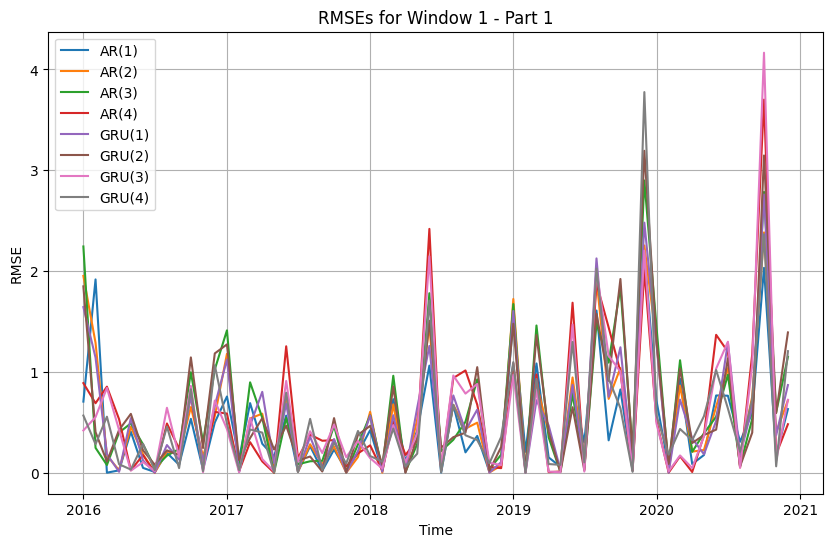

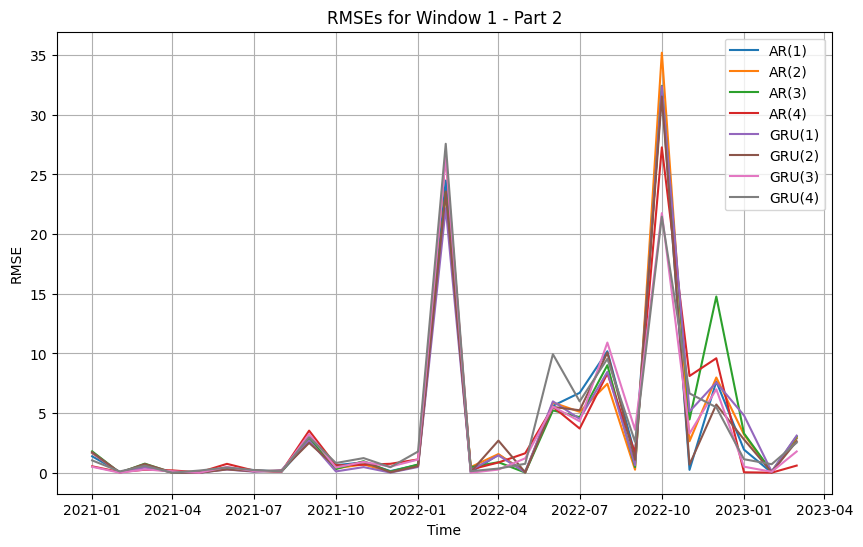

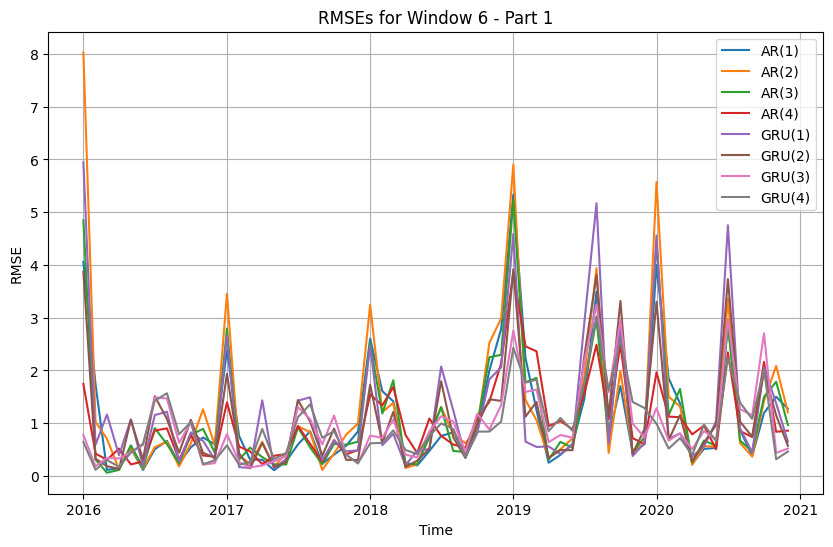

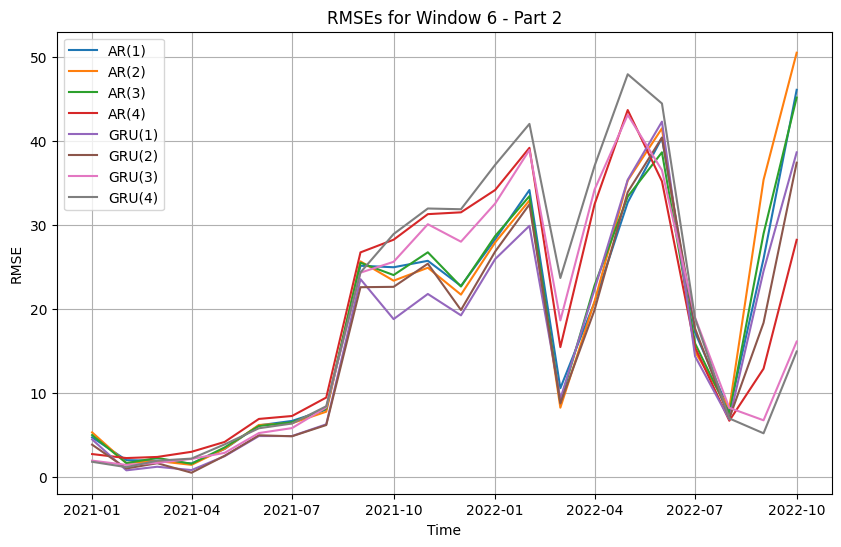

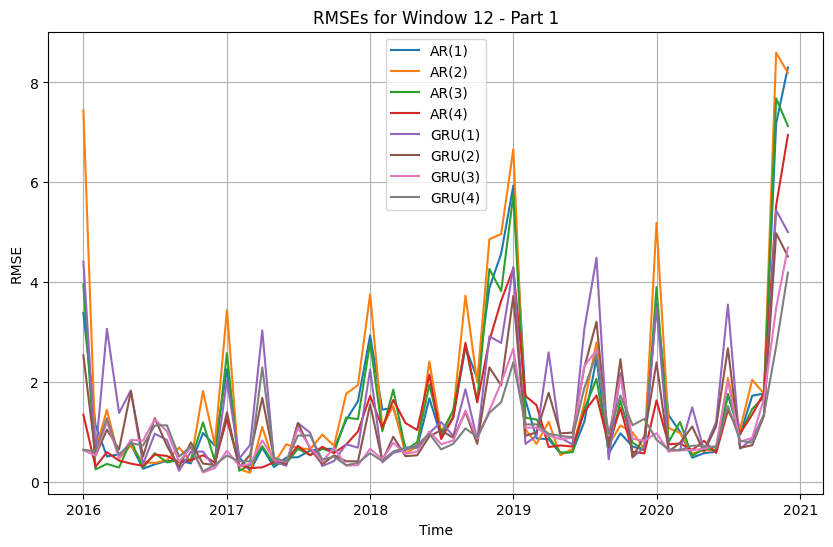

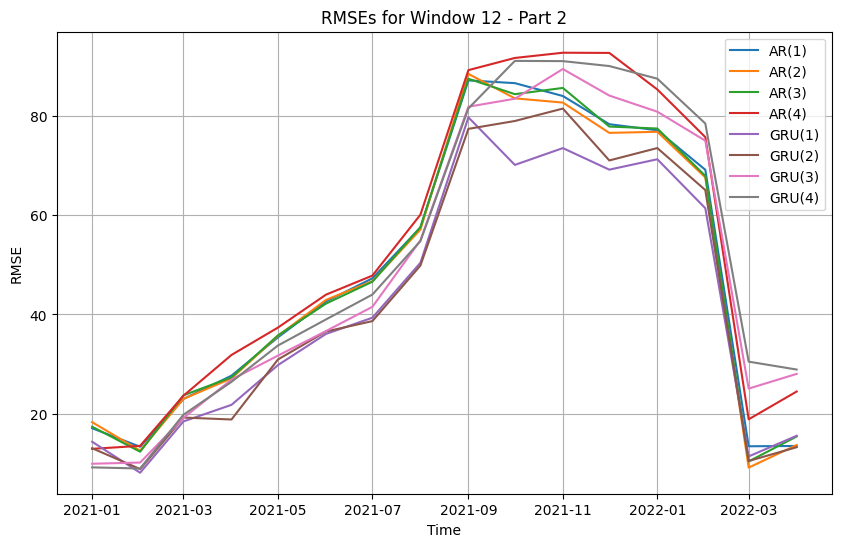

In [84]:
import matplotlib.pyplot as plt

model_dict = results  # Assuming 'results' is your dictionary
x_axis = months  # Assuming 'months' is your list for the x-axis

# Iterate over each window and create two plots for each window
for window in ['1', '6', '12']:
    for part in [1, 2]:  # Two parts: first 60 values (part 1) and the rest (part 2)
        plt.figure(figsize=(10, 6))

        for model in model_dict:
            rmses = model_dict[model][window]
            if part == 1:
                # First 60 values
                rmses_part = rmses[:60]
                x_labels = x_axis[:60]
            else:
                # Values after the first 60
                rmses_part = rmses[60:]
                x_labels = x_axis[60:len(rmses_part) + 60]

            plt.plot(x_labels, rmses_part, label=model)

        plt.xlabel('Time')
        plt.ylabel('RMSE')
        plt.title(f'RMSEs for Window {window} - Part {part}')
        plt.legend()
        plt.grid(True)
        plt.show()


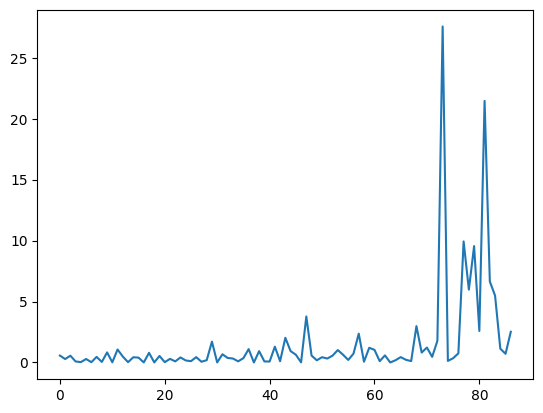

In [78]:
import matplotlib.pyplot as plt
plt.plot(results['GRU(4)']['1'])

In [76]:
np.mean(results['AR(4)']['1'])

1.5829455806676138

In [ ]:

mses_1 = []
mses_6 = []
mses_12 = []


for month in months:
    true = list(data.loc[month+pd.DateOffset(months=1):month+pd.DateOffset(months=12)])
    preds = ast.literal_eval(forecasts[(forecasts.model_specification=='AR(1)') & (forecasts.month==month)].forecast_values.values[0])
    ses = squared_errors(true, preds) 

    if len(ses) >= 1:
        mses_1 += [ses[0]]

    if len(ses) >= 6:
        mses_6 += [np.mean(ses[0:6])]

    if len(ses) >= 12:
        mses_12 += [np.mean(ses[0:12])]


In [63]:
months = [pd.to_datetime(month) for month in np.unique(forecasts.month)]

mses_1 = []
mses_6 = []
mses_12 = []


for month in months:
    true = list(data.loc[month+pd.DateOffset(months=1):month+pd.DateOffset(months=12)])
    preds = ast.literal_eval(forecasts[(forecasts.model_specification=='AR(1)') & (forecasts.month==month)].forecast_values.values[0])
    ses = squared_errors(true, preds) 

    if len(ses) >= 1:
        mses_1 += [ses[0]]

    if len(ses) >= 6:
        mses_6 += [np.mean(ses[0:6])]

    if len(ses) >= 12:
        mses_12 += [np.mean(ses[0:12])]


[104.44 104.98 106.11 105.82 105.67 106.67 107.32 106.16 106.82 106.01
 106.24 104.85]
[103.20482606 103.27939865 103.35371862 103.42778682 103.50160412
 103.57517136 103.64848939 103.72155905 103.79438119 103.86695664
 103.93928623 104.01137081]
[104.98 106.11 105.82 105.67 106.67 107.32 106.16 106.82 106.01 106.24
 104.85 105.77]
[104.52475089 104.60926463 104.69354188 104.77758332 104.86138959
 104.94496136 105.02829929 105.11140402 105.19427621 105.27691651
 105.35932557 105.44150404]
[106.11 105.82 105.67 106.67 107.32 106.16 106.82 106.01 106.24 104.85
 105.77 106.09]
[105.06889968 105.15757129 105.24601541 105.33423265 105.42222356
 105.50998874 105.59752877 105.68484422 105.77193567 105.85880369
 105.94544885 106.03187174]
[105.82 105.67 106.67 107.32 106.16 106.82 106.01 106.24 104.85 105.77
 106.09 107.14]
[106.20968744 106.30917322 106.40845774 106.50754142 106.60642466
 106.70510786 106.80359144 106.90187578 106.99996131 107.09784841
 107.19553749 107.29302896]
[105.67 106.

In [71]:
mses_1

[1.5256546577234138,
 0.20725175575746468,
 1.0838898855137622,
 0.15185630083831156,
 0.06004530115004903,
 0.8241245197720569,
 0.30042571866384205,
 1.6086759678683,
 0.321454208984287,
 0.8261713151493406,
 0.019911993858449033,
 2.190602153600965,
 0.7120792279595938,
 0.05625665019314324,
 0.9317565510208471,
 0.08632235068675867,
 0.17593470154830854,
 0.7662757770428886,
 0.763962860133804,
 0.30686062303116957,
 0.5957849246223585,
 2.0322441491143053,
 0.1753365057170517,
 0.6315269449146989,
 1.3745471548316832,
 0.0589415108046775,
 0.5939527732415077,
 0.003990639735617812,
 0.003929448250665026,
 0.3507020189844178,
 0.22646184766594063,
 0.07813227803602957,
 2.637285502710486,
 0.6304691440921117,
 0.8700419857363992,
 0.1356749211839574,
 0.6596830241410186,
 24.483573870724737,
 0.03420866245917565,
 1.5152109958551698,
 0.10890412483704807,
 5.603775515989196,
 6.6956366054662695,
 10.180169696267372,
 1.508632964485287,
 31.9696623381153,
 0.24032862749468428,
 7.64

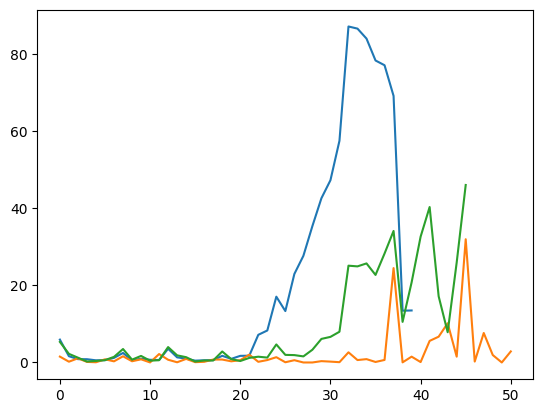

In [70]:
import matplotlib.pyplot as plt

plt.plot(mses_12)
plt.plot(mses_1)
plt.plot(mses_6)